In [1]:
import pandas as pd
import numpy as np
# import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# data source: https://www.nhtsa.gov/research-data/fatality-analysis-reporting-system-fars
# read data from Data files and put them into a list of dataframes
def readAccidentData():
    FileList = [ "FARS1975","FARS1976","FARS1977","FARS1978","FARS1979","FARS1980","FARS1981","FARS1982"
            ,"FARS1983","FARS1984","FARS1985","FARS1986","FARS1987","FARS1988","FARS1989","FARS1990"
            ,"FARS1991","FARS1992","FARS1993","FARS1994","FARS1995","FARS1996","FARS1997","FARS1998"
            ,"FARS1999","FARS2000","FARS2001","FARS2002","FARS2003","FARS2004","FARS2005","FARS2006"
            ,"FARS2007","FARS2008","FARS2009","FARS2010","FARS2011","FARS2012","FARS2013","FARS2014"
            ,"FARS2015"
           ]
    dfList = []
    print ("Reading accident data for each year from 1975 to 2015.")
    for i in FileList:
        tmpfilepath = "../Data/" + i + "/accident.csv"
        # print ("Reading ", tmpfilepath)
        tmpdf = pd.read_csv(tmpfilepath)
        # tmpSkimmedDf = tmpdf[['STATE', 'COUNTY',"FATALS"]].copy()
        dfList.append( pd.read_csv(tmpfilepath) )
        # dfList.append(tmpSkimmedDf)
    return dfList

# get the county codes, explanation: https://en.wikipedia.org/wiki/FIPS_county_code
def addcountyCode(dfList):
    for i in range(len(dfList)):
        dfList[i]['STATE'] = dfList[i]['STATE'].apply(lambda x: int(x))
        dfList[i]['STATE'] = dfList[i]['STATE'].apply(lambda x: '{0:0>2}'.format(x))
        dfList[i]['COUNTY'] = dfList[i]['COUNTY'].apply(lambda x: int(x))
        dfList[i]["COUNTY"] = dfList[i]["COUNTY"].apply(lambda x: '{0:0>3}'.format(x))
        dfList[i]["COUNTYCODE"] = dfList[i]["STATE"].astype(str)+dfList[i]["COUNTY"].astype(str)
        #print (dfList[i]['COUNTYCODE'])
    return dfList

# remove all the unnecessary columns, keep only countycode and deaths per year
def cleanDataFrame(myDfList_AccidentDataAll):
    dfList = []
    for df in myDfList_AccidentDataAll:
        tmp = df[["COUNTYCODE","FATALS"]].copy()
        tmpGrouped = tmp.groupby(['COUNTYCODE'], as_index=False).sum()
        dfList.append(tmpGrouped)
    return dfList
    

myDfList_AccidentDataAll = readAccidentData()
myDfList_AccidentDataAll = addcountyCode(myDfList_AccidentDataAll)
myDfList_AccidentData = cleanDataFrame(myDfList_AccidentDataAll)
del myDfList_AccidentDataAll

Reading accident data for each year from 1975 to 2015.


In [3]:
# read population data from 1969 to 2015 at county level
# data source: https://seer.cancer.gov/popdata/download.html#19
def readPopData():
    filename = "../Data/us.1969_2015.19ages.txt"
    print ("Reading ",filename, ": yearly county level population data from 1969 to 2015")
    f = open(filename,"r")
    L = f.read()
    L = L.split()
    
    # extract only year, county, and population information
    year = []
    county = []
    population = []
    for x in L:
        year.append(int(x[:4]))
        county.append( str(x[6:11]) )
        population.append(int(x[18:]))
    myDf = pd.DataFrame({"YEAR" : year, "COUNTYCODE":county,"POPULATION":population})
    return myDf

def cleanPopData(df_raw):
    tmp = df_raw.groupby(['COUNTYCODE','YEAR'], as_index=False).sum()
    return tmp

def createPopList(myDf_PopulationData):
    yearList = list(range(1975,2016))
    dfList = []
    for y in yearList:
        tmp = myDf_PopulationData[myDf_PopulationData["YEAR"] == y]
        dfList.append( tmp )
    return dfList  
    
    
myDf_RawPopulationData = readPopData()
myDf_PopulationData = cleanPopData(myDf_RawPopulationData)
myDfList_PopData = createPopList(myDf_PopulationData)

Reading  ../Data/us.1969_2015.19ages.txt : yearly county level population data from 1969 to 2015


In [4]:
def readFPISCodes():
    df = pd.read_excel("../Data/US_FIPS_Codes.xls", dtype=object)
    df["COUNTYCODE"] = df["FIPS State"]+df["FIPS County"]
    df["COUNTY"] = df["State"]+","+df["County Name"]
    tmp = df[['COUNTYCODE', 'COUNTY']].copy()
    return tmp

dfFPIS = readFPISCodes()
myDict_FPIS = dfFPIS.set_index('COUNTYCODE').to_dict()
myCountyCodeList = list(dfFPIS["COUNTYCODE"])

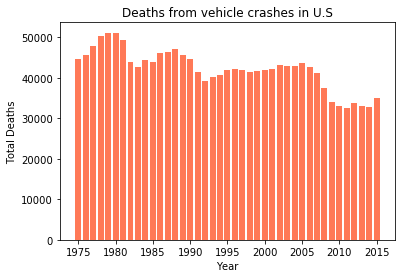

In [8]:
# plot the total deaths per year and plot
def getFatalList(myDfList_AccidentData):
    FatalList = []
    YearList = []
    for i in range(len(myDfList_AccidentData)):
        FatalList.append( myDfList_AccidentData[i]["FATALS"].sum()  )
        YearList.append( i+1975 )
    return YearList,FatalList

yearList, fatalList = getFatalList(myDfList_AccidentData)
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
# ax.plot(yearList, fatalList)
ax.bar(yearList,fatalList, alpha=0.8,color='#ff572d')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title("Deaths from vehicle crashes in U.S")
fig.savefig('../Fig/TotalDeathvsYear.pdf')
plt.show()
plt.close(fig) # close the figure

In [11]:
def mergeAccidentandCrashData(myDfList_AccidentData,myDfList_PopData):
    dfList = []
    for i in range(len(myDfList_AccidentData)):
        tmp = pd.merge(myDfList_AccidentData[i], myDfList_PopData[i], on='COUNTYCODE', how='inner')
        dfList.append(tmp)
    
    return dfList

myDfList_MergedData = mergeAccidentandCrashData(myDfList_AccidentData,myDfList_PopData)
# myDfList_MergedData[0]
# myDfList_PopData[40]
# myDfList_AccidentData[40]

In [12]:
def shrinkFitRange(yearList,deathList):
   
    i = 0
    y = deathList
    x = yearList
    while (deathList[i]==0) and i < (len(deathList)-1):
        y = deathList[i+1:]
        x = yearList[i+1:]
        i = i+1

    i = len(y)-1
    new_x = x
    new_y = y
    while (y[i]==0) and (i > 0):
        new_y = y[:i-1]
        new_x = x[:i-1]
        i = i-1
    
    return new_x,new_y

In [13]:

        
def plotDeathRatePerCounty(myDfList_AccidentData,myDict_FPIS,countyCode,county_highestPopIncrease,county_highestPopDecrease,p0Inc,p0Dec):
    deathList = []
    yearList = np.arange(1975,2016)
    for i in range(len(myDfList_AccidentData)):
        tmp = myDfList_AccidentData[i]
        tmp = tmp[ tmp["COUNTYCODE"] == countyCode ]
        deathList.append( tmp["FATALS"].sum())

        
    shrinkedYearList,shrinkedDeathList = shrinkFitRange(yearList,deathList)
    # slope, intercept, r_value, p_value, std_err = stats.linregress(yearList,deathList)
    p = np.polyfit(shrinkedYearList,shrinkedDeathList,1)
    f = np.poly1d(p)
    
    
    # print (shrinkedYearList)
    # calculate new x's and y's
    x_new = np.linspace(shrinkedYearList[0], shrinkedYearList[-1], 100)
    y_new = f(x_new)
    
#     textstr = 'y=%.2f*x + %.2f'%(p[0], p[1])
#     fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
#     ax.plot(yearList,deathList,"ro", x_new, y_new)
#     # these are matplotlib.patch.Patch properties
#     props = dict(boxstyle='round', facecolor='green', alpha=0.5)
#     # place a text box in upper left in axes coords
#     ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
#     plt.xlabel('Year')
#     plt.ylabel('Total Deaths')
#     plt.title(myDict_FPIS["COUNTY"][countyCode])
#     # plt.show()
#     figName = '../Fig/LinearFitTotalDeaths_'+countyCode+'.pdf'
#     fig.savefig(figName)
#     plt.close(fig) # close the figure
    
    if p[0]>p0Inc: 
        p0Inc = p[0]
        county_highestPopIncrease = countyCode
    if p[0]<p0Dec: 
        p0Dec = p[0]
        county_highestPopDecrease = countyCode
        
    return f(2016),county_highestPopIncrease, county_highestPopDecrease,p0Inc,p0Dec

county_highestPopIncrease = 0
county_highestPopDecrease = 0
p0Inc = 0
p0Dec = 0

# num, county_highestPopIncrease, county_highestPopDecrease, p0Inc, p0Dec = plotDeathRatePerCounty(myDfList_AccidentData,myDict_FPIS,"05015",county_highestPopIncrease,county_highestPopDecrease,p0Inc,p0Dec)



crashRatePrediction_2016 = {}
for countyCode in myCountyCodeList:
    num, county_highestPopIncrease, county_highestPopDecrease, p0Inc, p0Dec = plotDeathRatePerCounty(myDfList_AccidentData,myDict_FPIS,countyCode,county_highestPopIncrease,county_highestPopDecrease,p0Inc,p0Dec)
    crashRatePrediction_2016[countyCode] = num
    
print("Pop increase: ",county_highestPopIncrease, " Pop decrease: ",county_highestPopDecrease)
# output : Pop increase:  32003  Pop decrease:  06037

/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


TypeError: expected non-empty vector for x

In [17]:
def adjustMissingInformation(populationList):
    for i in range(len(populationList)):
        if i==0 and populationList[i]==0:
            populationList[i] = populationList[i+1]
        if i==(len(populationList)-1) and populationList[len(populationList)-1]==0:
            populationList[len(populationList)-1] = populationList[len(populationList)-2]
        if i<(len(populationList)-1) and i > 0 and populationList[i] == 0:
            populationList[i] = (populationList[i-1]+populationList[i+1])/2
    return populationList
    

In [60]:
def plotPopIncreasePerCounty(myDfList_PopData,myDict_FPIS,countyCode,county_highestIncrease_pop, county_highestDecrease_pop,changeMax,changeMin):
    yearList = np.arange(1975,2016)
    populationList = np.empty([len(yearList)])
    
    for i in range(len(myDfList_PopData)):
        tmp = myDfList_PopData[i]
        tmp = tmp[ tmp["COUNTYCODE"] == countyCode ]
        populationList[i] = tmp["POPULATION"].sum()
    
    # just average the missing information
#     populationList = adjustMissingInformation(populationList)
    shrinkedYearList,shrinkedPopList = shrinkFitRange(yearList,populationList)
    # slope, intercept, r_value, p_value, std_err = stats.linregress(yearList,deathList)
    p = np.polyfit(shrinkedYearList,shrinkedPopList,5)
    f = np.poly1d(p)

    # calculate new x's and y's
    x_new = np.linspace(shrinkedYearList[0], shrinkedYearList[-1], 100)
    y_new = f(x_new)
    

    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
    ax.plot(yearList,populationList,"ro", x_new, y_new)
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    #ax.text(0.40, 0.15, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    plt.xlabel('Year')
    plt.ylabel('Total Population')
    plt.title(myDict_FPIS["COUNTY"][countyCode])
    #plt.show()
    figName = '../Fig/LinearPopulationIncreaseFit_'+countyCode+'.pdf'
    fig.savefig(figName)
    plt.close(fig) # close the figure
    
    rate = shrinkedPopList[-1]/shrinkedPopList[0]
    #print(rate)
    if rate>changeMax: 
        changeMax = rate
        county_highestIncrease_pop = countyCode
    if rate<changeMin: 
        changeMin = rate
        county_highestDecrease_pop = countyCode
    
    return f(2016),county_highestIncrease_pop, county_highestDecrease_pop, changeMax, changeMin


county_highestIncrease_pop = 0
county_highestDecrease_pop = 0
changeMax = 0
changeMin = 0


# num, county_highestIncrease_pop, county_highestDecrease_pop, changeMax, changeMin = plotPopIncreasePerCounty(myDfList_PopData,myDict_FPIS,"02280",county_highestIncrease_pop, county_highestDecrease_pop,changeMax,changeMin)
# num

populationPrediction_2016 = {}
for countyCode in myCountyCodeList:
    num, county_highestIncrease_pop, county_highestDecrease_pop, changeMax, changeMin = plotPopIncreasePerCounty(myDfList_PopData,myDict_FPIS,countyCode,county_highestIncrease_pop, county_highestDecrease_pop,changeMax,changeMin)
    populationPrediction_2016[countyCode] = num

print("Max pop increase rate: ", county_highestIncrease_pop, "Min pop increase: ",county_highestDecrease_pop)
#output: Max pop increase rate:  08035 Min pop increase:  0

/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


Max pop increase rate:  08035 Min pop increase:  0


In [69]:
df_Crash2016 = pd.DataFrame()
df_Crash2016["CountyCode"] = crashRatePrediction_2016.keys()
df_Crash2016["Fatals"] = crashRatePrediction_2016.values()

df_Population2016 = pd.DataFrame()
df_Population2016["CountyCode"] = populationPrediction_2016.keys()
df_Population2016["Population"] = populationPrediction_2016.values()
#df_Population2016
#df_Crash2016

In [67]:
df_FinalData =  pd.merge(df_Crash2016, df_Population2016, on='CountyCode', how='outer')
df_FinalData["FatalityRate"] = 10000*df_FinalData["Fatals"]/df_FinalData["Population"]
df_FinalData.to_csv("../CreateSVG/FatalityData.csv",header=False, index = False)

In [58]:
def smoothDeathRate(deathList):
    for i in range(len(deathList)):
        if i==0:
            deathList[i] = (deathList[i] + deathList[i+1]) /2.0
        if i==(len(deathList)-1):
            deathList[len(deathList)-1] = (deathList[len(deathList)-1]+ deathList[len(deathList)-2])/2.0
        if i<(len(deathList)-1) and i > 0:
            deathList[i] = (deathList[i-1]+deathList[i]+deathList[i+1])/3.0
    return deathList

In [59]:
############################benchmarking###################################
############################benchmarking###################################
############################benchmarking###################################
############################benchmarking###################################
############################benchmarking###################################
############################benchmarking###################################
############################benchmarking###################################


def plotDeathRatePerCountyBenchMark(myDfList_AccidentData,myDict_FPIS,countyCode):
    deathList = []
    yearList = np.arange(1975,2015)
    
    for i in range(len(myDfList_AccidentData)-1):
        tmp = myDfList_AccidentData[i]
        tmp = tmp[ tmp["COUNTYCODE"] == countyCode ]
        deathList.append( tmp["FATALS"].sum())
 
    # deathList = smoothDeathRate(deathList)
    shrinkedYearList,shrinkedDeathList = shrinkFitRange(yearList,deathList)
    if(len(shrinkedYearList)<2): return 0
    p = np.polyfit(shrinkedYearList,shrinkedDeathList,1)
    f = np.poly1d(p)
    return f(2015)

crashRatePrediction_2015 = {}
for countyCode in myCountyCodeList:
    num = plotDeathRatePerCountyBenchMark(myDfList_AccidentData,myDict_FPIS,countyCode)
    if num<0:
        crashRatePrediction_2015[countyCode] = 0
    else:
        crashRatePrediction_2015[countyCode] = num



In [21]:
def plotPopIncreasePerCountyBenchMark(myDfList_PopData,myDict_FPIS,countyCode):
    yearList = np.arange(1975,2015)
    populationList = np.empty([len(yearList)])
    
    for i in range(len(myDfList_PopData)-1):
        tmp = myDfList_PopData[i]
        tmp = tmp[ tmp["COUNTYCODE"] == countyCode ]
        populationList[i] = tmp["POPULATION"].sum()
    
    shrinkedYearList,shrinkedPopList = shrinkFitRange(yearList,populationList)
    p = np.polyfit(shrinkedYearList,shrinkedPopList,5)
    f = np.poly1d(p)  
    return f(2015)

populationPrediction_2015 = {}
for countyCode in myCountyCodeList:
    num = plotPopIncreasePerCountyBenchMark(myDfList_PopData,myDict_FPIS,countyCode)
    if num<0:
        populationPrediction_2015[countyCode] = 0
    else:
        populationPrediction_2015[countyCode] = num


/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWar

In [60]:
# populationPrediction_2015
# crashRatePrediction_2015

df_Crash2015 = pd.DataFrame()
df_Crash2015["CountyCode"] = crashRatePrediction_2015.keys()
df_Crash2015["Fatals"] = crashRatePrediction_2015.values()

df_Population2015 = pd.DataFrame()
df_Population2015["CountyCode"] = populationPrediction_2015.keys()
df_Population2015["Population"] = populationPrediction_2015.values()

df_2015Prediction =  pd.merge(df_Crash2015, df_Population2015, on='CountyCode', how='outer')
df_2015Prediction["FatalityRatePrediction"] = 10000*df_2015Prediction["Fatals"]/df_2015Prediction["Population"]
df_2015Prediction.to_csv("../CreateSVG/FatalityPredictionData_2015.csv",header=False, index = False)



df_2015ActualData = pd.merge(myDfList_AccidentData[40], myDfList_PopData[40], on='COUNTYCODE', how='inner')
df_2015ActualData["FatalityRateActual"] = 10000*df_2015ActualData["FATALS"]/df_2015ActualData["POPULATION"]
df_2015ActualData = df_2015ActualData.rename(columns={'COUNTYCODE': 'CountyCode', 'FATALS': 'Fatals', 'POPULATION': 'Population',"YEAR":"Year"})
# df_2015ActualData



In [141]:
df_BenchMark = pd.merge(df_2015Prediction, df_2015ActualData, on='CountyCode', how='inner')
df_BenchMark["Error"] = 100*abs(df_BenchMark["FatalityRateActual"]-df_BenchMark["FatalityRatePrediction"])/df_BenchMark["FatalityRateActual"]
# df_BenchMark["Error"].mean()
tmp = df_BenchMark[df_BenchMark["Population_y"]>100000]
tmp["Error"].mean()
#df_BenchMark

24.284899058352725